In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
%cd /content/drive/My Drive/CS594 - DNLP/Assignments/Assignment 1/

/content/drive/My Drive/CS594 - DNLP/Assignments/Assignment 1


In [1]:
import pandas as pd
import numpy as np
import os
# import src
import matplotlib.pyplot as plt

In [2]:
pip install -U mittens

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from mittens import GloVe, Mittens

In [4]:
pip install autocorrect

Note: you may need to restart the kernel to use updated packages.


In [5]:
import nltk
# nltk.download()
import string
from nltk.tokenize import word_tokenize
import random
import pickle
from nltk.corpus import stopwords

from autocorrect import Speller
# from pycontractions import Contractions

# from spellchecker import SpellChecker

import re
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer 

from hyperopt import fmin, tpe, hp

In [6]:
from numpy import asarray
from numpy import zeros
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dropout, MaxPool1D
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional

In [7]:
# nltk.download('all')

In [ ]:
# # Load your favorite word2vec model
# cont = Contractions('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz')
# text = "we're"
# text = list(cont.expand_texts([text], precise=True))[0]

In [8]:
def conv_dataframes(pos_path, neg_path):
    with open(pos_path,'r',encoding='latin1') as f:
        data_p = f.readlines()
#     print(data_p[11])
    with open(neg_path,'r',encoding='latin1') as f:
        data_n = f.readlines()
    pos_data = shuffle(pd.DataFrame(data_p, columns = ["Doc Text"]))
#     pos_data['Sentiment'] = 1
#     pos_data.columns = ["Doc Text", "Sentiment"]
    neg_data = shuffle(pd.DataFrame(data_n, columns = ["Doc Text"]))
#     neg_data['Sentiment'] = -1
#     neg_data.columns = ["Doc Text", "Sentiment"]
    return pos_data, neg_data


## The code for pos tagging and lemmatize sentence is fron the following link:
 ### https://medium.com/@gaurav5430/using-nltk-for-lemmatizing-sentences-c1bfff963258

In [9]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [10]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
#     print(wordnet_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
#         if tag is not None:
#             lemmatized_sentence.append(lemmatizer.lemmatize(word, tag)) 

    return " ".join(lemmatized_sentence)

In [11]:
# print(lemmatizer.lemmatize("I am loving it")) #I am loving it
# print(lemmatizer.lemmatize("loving")) #loving
# print(lemmatizer.lemmatize("loving", "v")) #love
# print(lemmatize_sentence("I am loving it")) #I be love it

In [12]:
def text_preprocessing(data):
    data["Doc Text"] = data["Doc Text"].str.replace('\n\n', ' ')
    data["Doc Text"] = data["Doc Text"].str.replace('[^\w\s]',' ')
    data["Doc Text"] = data["Doc Text"].str.replace('\s+[a-zA-Z]\s+',' ')
    data["Doc Text"] = data["Doc Text"].str.replace('\^[a-zA-Z]\s+',' ')

    data["Doc Text"] = data["Doc Text"].str.replace('\s+',' ')

    # Remove stop words from text
    data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_list]))
    
#     data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([lemmatizer.lemmatize(y) for y in x.split()]))
    data["Doc Text"] = data["Doc Text"].apply(lambda x: lemmatize_sentence(x))

    return data

In [13]:
def create_vocab(pos_data, neg_data):
    temp_pos = text_preprocessing(pos_data)
    temp_neg = text_preprocessing(neg_data)
#     temp_pos2 = np.asarray([word_tokenize(re.sub(r"\b[a-zA-Z]\b", " ",i)) for i in temp_pos['Doc Text']])
#     temp_neg2 = np.asarray([word_tokenize(re.sub(r"\b[a-zA-Z]\b", " ",i)) for i in temp_neg['Doc Text']]) 
#     temp_pos["Doc Text Tokens"] = temp_pos2 
#     temp_neg["Doc Text Tokens"] = temp_neg2
    return temp_pos, temp_neg

In [ ]:
file_path  = 'rt-polaritydata' 
pos_path = os.path.join(file_path, 'rt-polarity.pos')
neg_path = os.path.join(file_path, 'rt-polarity.neg')

In [ ]:
pos_data, neg_data = conv_dataframes(pos_path, neg_path)
pos_data.head()

what really surprises about wisegirls is its low-key quality and genuine tenderness . 



,Doc Text
53,sandra nettelbeck beautifully orchestrates the...
1710,"a sensitive , moving , brilliantly constructed..."
460,"it's fun , but the code-talk will fly right ov..."
1786,you might want to take a reality check before ...
2848,"all comedy is subversive , but this unrelentin..."


In [ ]:
pos_data['Doc Text'][11]

'what really surprises about wisegirls is its low-key quality and genuine tenderness . \n'

In [ ]:
# hm_lines = 5331

# tokenizer = nltk.RegexpTokenizer(r"\w+")
# spell = Speller(lang='en')
# # spell = SpellChecker()

# stop_words = set(stopwords.words('english'))
stop_list = stopwords.words('english')

lemmatizer = WordNetLemmatizer() 

vocab_p, vocab_n = create_vocab(pos_data, neg_data)

vocab_p['Sentiment'] = 1
vocab_n['Sentiment'] = 0

In [ ]:
vocab_p.head()

,Doc Text,Sentiment
53,sandra nettelbeck beautifully orchestrate tran...,1
1710,sensitive move brilliantly construct work,1
460,fun code talk fly right everyone head,1
1786,might want take reality check pay full ticket ...,1
2848,comedy subversive unrelenting bleak insistence...,1


In [ ]:
len(vocab_p)

5331

## Splitting the data into training, validation, and testing

In [ ]:
vocab_p_train1, vocab_p_test= train_test_split(vocab_p, test_size = 0.2)
vocab_p_train, vocab_p_val = train_test_split(vocab_p_train1, test_size = 0.25)
vocab_p_test.head()

,Doc Text,Sentiment
3649,visual delight decent popcorn adventure long t...,1
3334,problem lady duke surprisingly manage never gr...,1
1423,pumpkin take admirable look hypocrisy politica...,1
40,newton draw attention like magnet act circle a...,1
3491,film belongs marvelous verdu sexy slip earth m...,1


In [ ]:
vocab_p_train.head()

,Doc Text,Sentiment
466,film exhilarate watch sandler liberate constra...,1
1187,fall neatly category good stupid fun,1
541,life affirm vulgar mean like,1
1030,everything love 1982 still everybody want kid ...,1
4389,time do us mira nair new movie audience giddy ...,1


In [ ]:
vocab_n_train1, vocab_n_test= train_test_split(vocab_n, test_size = 0.2)
vocab_n_train, vocab_n_val = train_test_split(vocab_n_train1, test_size = 0.25)
vocab_n_test.head()

,Doc Text,Sentiment
3503,certain cue like happy music suggest movie sup...,0
2333,say fuhgeddaboutit,0
1404,worth see charm quickly fade,0
469,movie weigh glass flat champagne,0
3918,deserves high mark political courage barely ge...,0


In [ ]:
training = shuffle(pd.concat([vocab_p_train,vocab_n_train])).reset_index(drop = True)

validation = pd.concat([vocab_p_val,vocab_n_val]).reset_index(drop = True)

test = pd.concat([vocab_p_test,vocab_n_test]).reset_index(drop = True)
# len(validation)

In [ ]:
training.head()

,Doc Text,Sentiment
0,old cad instructs young lad zen art get laid p...,1
1,movie always easy look indeed duty art reflect...,1
2,fill honest performance exceptional detail bar...,1
3,dialogue cumbersome simper soundtrack edit,0
4,less front load shapely two hour version relea...,1


In [ ]:
# training.to_csv('Training Data1.csv')
# validation.to_csv('Validation Data1.csv')
# test.to_csv('Test Data1.csv')

In [14]:
training = pd.read_csv('Training Data1.csv').iloc[:,1:]

training.head()

,Doc Text,Sentiment
0,film try touch spousal abuse veers course beco...,0
1,affleck merely create outline role still need ...,0
2,make esther kahn demand progress low key manne...,1
3,film bright flashy right way,1
4,far gloss still feel director denis villeneuve...,1


In [15]:
validation = pd.read_csv('Validation Data1.csv').iloc[:,1:]

validation.head()

,Doc Text,Sentiment
0,film welcome breeziness unbelievably hilarious...,1
1,subtle poignant picture goodness flaw compromi...,1
2,oddity sure one might wind remember degree aff...,1
3,gleefully grungy hilariously wicked black comedy,1
4,may genial ingenious get job do,1


## Building Glove Dictionary

In [16]:
embeddings = {}
with open("glove.6B.300d.txt", 'r', encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = asarray(values[1:], dtype='float32')
        embeddings[word] = vector

## Embedding Matrix Function

In [17]:
def emb_matrix(t,embeddings):
    # creating a embedding matrix for the words in training data, which will be used as weight matrix for embedding layer
    vocab_size = len(t.word_index) + 1    
    embedding_matrix = zeros((vocab_size, 300))
    for word, i in t.word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, vocab_size

## Building Vanilla RNN, LSTM, and GRU models

In [18]:
def model_vanilla_rnn(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(SimpleRNN(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [19]:
def model_lstm(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(LSTM(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [20]:
def model_gru(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(GRU(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [97]:
# max_length = 40
# epochs = 15
# batch_size = 128
# learning_rate = 0.001

# encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
# training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
# embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

# encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
# validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')

# adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
# model = model_vanilla_rnn(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

# history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
# accuracy = history.history['val_accuracy'][-1]



In [ ]:
# u = {}
# u['max_len'] = max_length
# u['batch'] = batch_size
# u['l_rate'] = learning_rate
# u['epochs'] = epochs

# fig, ax = plt.subplots(1,2,figsize = (20,5))

# ax[0].plot(history.history['loss'], label='Training')
# ax[0].plot(history.history['val_loss'], c='r',label='Validation')
# ax[0].legend(loc='upper left')
# ax[0].title.set_text('Loss plot for the combination ' + str(u)) 

# ax[1].plot(history.history['accuracy'], label='Training')
# ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
# ax[1].legend(loc='upper left')
# ax[1].title.set_text('Accuracy plot for the combination ' + str(u))    

## Using Hyperopt library to tune the Hyperparameters. Here we are splitting the training further into validation with split size 0f 0.25 (which is 0.2 of original data)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

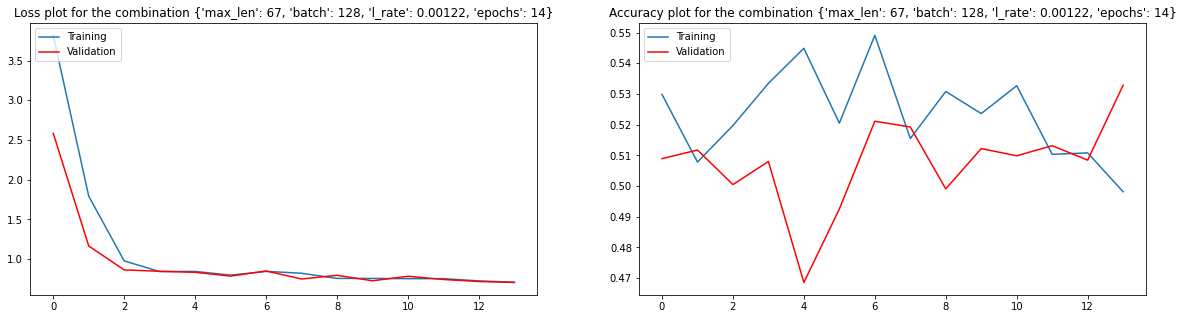

 10%|█         | 1/10 [00:34<05:06, 34.04s/it, best loss: -0.5299999713897705]

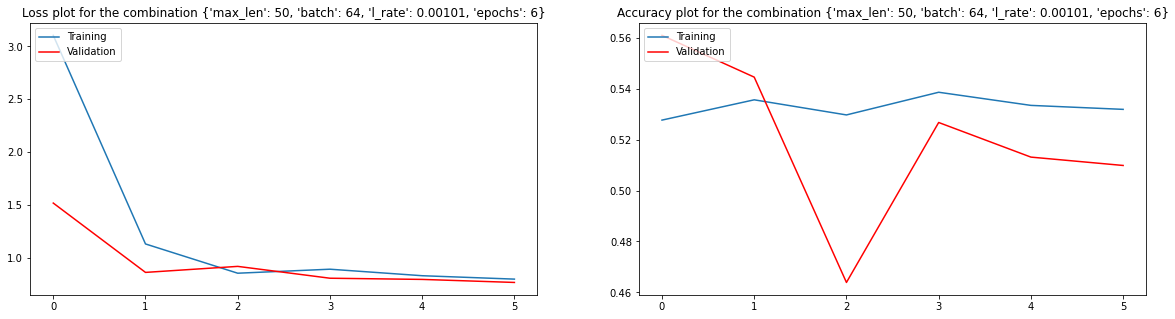

 20%|██        | 2/10 [01:00<04:13, 31.66s/it, best loss: -0.5299999713897705]

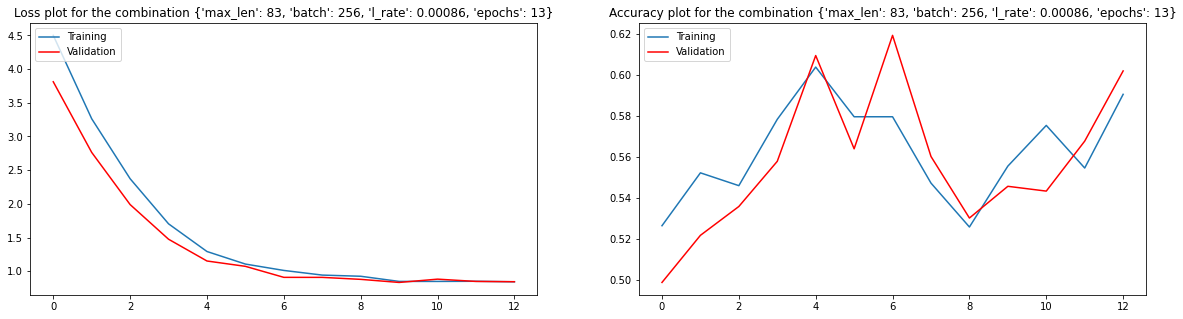

 30%|███       | 3/10 [01:37<03:47, 32.47s/it, best loss: -0.6000000238418579]


KeyboardInterrupt: ignored

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = round(history.history['val_accuracy'][-1],2)
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

    return -round(accuracy,2)

space = {'max_length': hp.choice('max_length',range(4,100)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_vanilla_rnn = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_vanilla_rnn)

In [ ]:
{'batch_size': 0, 'epochs': 7, 'max_length': 59, 'padd': 0, 'trunc': 0}

In [23]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_lstm(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = round(history.history['val_accuracy'][-1],2)
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

    return -round(accuracy,2)

space = {'max_length': hp.choice('max_length',range(4,50)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_lstm = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_lstm)

  0%|          | 0/10 [01:31<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]WARNING:tensorflow:Layer gru will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


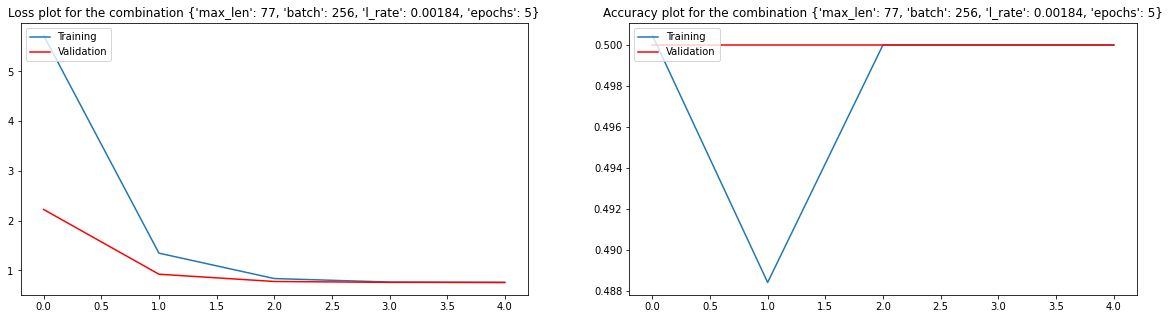

 10%|█         | 1/10 [00:32<04:54, 32.77s/it, best loss: -0.5]


KeyboardInterrupt: ignored

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']
    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')

    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre') 
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_gru(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,50)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_gru = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_gru)

## Taking elementwise max of the hidden states

In [25]:
def model_vanilla_rnn_em(embedding_matrix, noh, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(SimpleRNN(units = noh, activation = activation,return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(MaxPool1D(max_length, strides = None))
#     model.add(Dropout(Dropout_rate))

#     model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    
#     print(z)
    return model


In [26]:
def model_lstm_em(embedding_matrix, noh, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(LSTM(units = noh, activation = activation,return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(MaxPool1D(max_length, strides = None))
#     model.add(Dropout(Dropout_rate))

#     model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    
#     print(z)
    return model


In [27]:
def model_gru_em(embedding_matrix, noh, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(GRU(units = noh, activation = activation,return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.add(MaxPool1D(max_length, strides = None))
#     model.add(Dropout(Dropout_rate))

#     model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    
#     print(z)
    return model


In [28]:
# max_length = 40
# epochs = 15
# batch_size = 128
# encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
# training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
# embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

# model = model_vanilla_rnn_em(embedding_matrix, vocab_size, max_length, 'tanh', 0.2, 0.001, 0.001)

# history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True, validation_split = 0.2)
# accuracy = history.history['val_accuracy'][-1]

## max_length = 40
## epochs = 15
## batch_size = 64
## learning_rate = 0.001

In [29]:

def par_selec(model_r, max_length, nnh):
  # max_length = 40
  epochs = 15
  batch_size = 64
  learning_rate = 0.001

  tokenise_tf = Tokenizer()
  tokenise_tf.fit_on_texts(training['Doc Text']) 

  encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
  training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')

  embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

  encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
  validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')


  adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
  model = model_r(embedding_matrix, nnh, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

  history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
  accuracy = history.history['val_accuracy'][-1]

  u = {}
  u['max_len'] = max_length
  u['batch'] = batch_size
  u['l_rate'] = learning_rate
  u['epochs'] = epochs

  fig, ax = plt.subplots(1,2,figsize = (20,5))

  ax[0].plot(history.history['loss'], label='Training')
  ax[0].plot(history.history['val_loss'], c='r',label='Validation')
  ax[0].legend(loc='upper left')
  ax[0].title.set_text('Loss plot for the combination ' + str(u))


  ax[1].plot(history.history['accuracy'], label='Training')
  ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
  ax[1].legend(loc='upper left')
  ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
  plt.show()

  print('Accuracy for ' + str(nnh) + ' hidden units ' + str(max_length) + ' sequence length: ' + str(accuracy))


## Changing the no of hidden units
## Keeping max_length = 40
## epochs = 15
## batch_size = 64
## learning_rate = 0.001


In [30]:
par_selec(model_vanilla_rnn_em, 40, 300)

KeyboardInterrupt: 

In [ ]:
par_selec(model_lstm_em, 40, 300)

In [ ]:
par_selec(model_gru_em, 40, 300)

## Doubling the no of hidden units

In [ ]:
par_selec(model_vanilla_rnn_em, 40, 300)

### For Vanilla RNN,  With double the no of hidden units, the accuracy reduced from 74 to 73 percent.

In [ ]:
par_selec(model_lstm_em, 40, 600)

### For LSTM, With double the no of hidden units, the accuracy reduced from 74 to 73 percent.

In [ ]:
par_selec(model_gru_em, 40, 600)

### For GRU, With double the no of hidden units, the accuracy reduced from 74 to 73 percent.

# Halving the no of hidden units

In [ ]:
par_selec(model_vanilla_rnn_em, 40, 150)

### With halve the no of hidden units, the accuracy increased slightly from 73.8 to 74.4.

In [ ]:
par_selec(model_lstm_em, 40, 150)

### For LSTM, With halve the no of hidden units, the accuracy reduced from 74 to 73 percent.

In [ ]:
par_selec(model_gru_em, 40, 150)

### For GRU, With halve the no of hidden units, the accuracy reduced from 74 to 73 percent.

# Changing the max_length 
# Keeping no of hidden units = 300
# epochs = 15
# batch_size = 64
# learning_rate = 0.001


## Doubling the sequence length from 40 to 80

In [ ]:
par_selec(model_vanilla_rnn_em, 80, 300)

### For vanilla rnn, With double the sequence length, there was an insignificant increase in accuracy from 73.83 to 73.87



In [ ]:
par_selec(model_lstm_em, 80, 300)

### For LSTM, With double the sequence length, there was an insignificant increase in accuracy from 73.83 to 73.87



In [ ]:
par_selec(model_gru_em, 80, 300)

### For GRU, With double the sequence length, there was an insignificant increase in accuracy from 73.83 to 73.87



### When we increase the sequence length we might include important words that would change the sentiment of the sentence

## Halving the sequence length from 40 to 20

In [ ]:
par_selec(model_vanilla_rnn_em, 20, 300)

### For vanilla RNN, With half the sequence length, there was a slight decrease in accuracy from 73.8 to 73.2


In [ ]:
par_selec(model_lstm_em, 20, 300)

### For LSTM, With half the sequence length, there was a slight decrease in accuracy from 73.8 to 73.2


In [ ]:
par_selec(model_gru_em, 20, 300)

### For GRU, With half the sequence length, there was a slight decrease in accuracy from 73.8 to 73.2



### It makes sense as when we decrease the sequence length we might lose important words that change the sentiment of the sentence

###

## Fine tuning the word embeddings using mittens library

In [ ]:
def finetune(training): 
  training_tokens = [word_tokenize(i) for i in training['Doc Text']]
  print(training_tokens)
  #training_tokens

  oov = [j for i in training_tokens for j in i if j not in embeddings.keys()]
  print(len(oov))

  corp_vocab = list(set(oov))

  cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
  trr =''
  for i in training_tokens:
    for j in i:
      trr+= j
      trr += ' '

  # print(trr)
  # print(z)
  X = cv.fit_transform([trr])
  Xc = (X.T * X)
  Xc.setdiag(0)
  coocc_ar = Xc.toarray()

  mittens_model = Mittens(n=300, max_iter=1000)

  new_embeddings = mittens_model.fit(
      coocc_ar,
      vocab=corp_vocab,
      initial_embedding_dict= embeddings)

  new_embeddings = dict(zip(corp_vocab, new_embeddings))
  return new_embeddings
  


In [ ]:
embeddings2= embeddings.copy()
embeddings2.update(finetune(training))

In [ ]:
oov2 = [j for i in training_tokens for j in i if j not in embeddings2.keys()]
print(len(oov2))

### Using new embeddings for the vanilla rnn em

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')

    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings2)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre') 
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn_em(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round(accuracy,2)

space = {'max_length': hp.choice('max_length',range(4,100)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_vanilla_rnn_em = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_vanilla_rnn_em)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

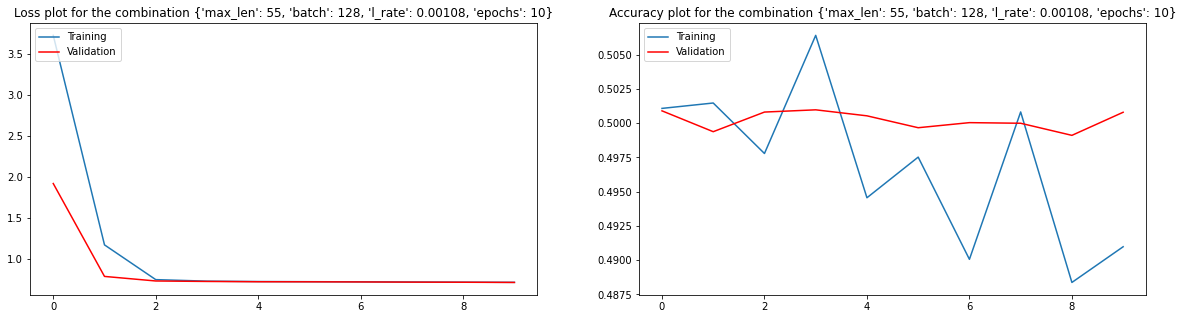

 10%|█         | 1/10 [00:15<02:18, 15.38s/it, best loss: -0.5]

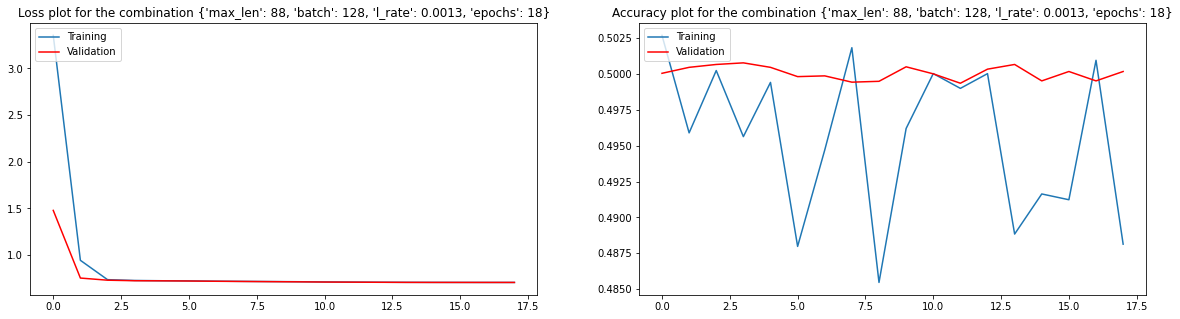

 20%|██        | 2/10 [00:56<03:05, 23.19s/it, best loss: -0.5]

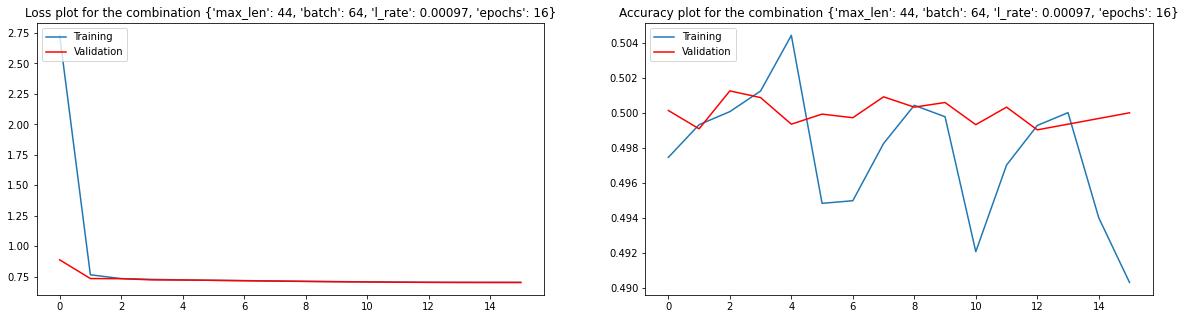

 30%|███       | 3/10 [01:34<03:13, 27.64s/it, best loss: -0.5]

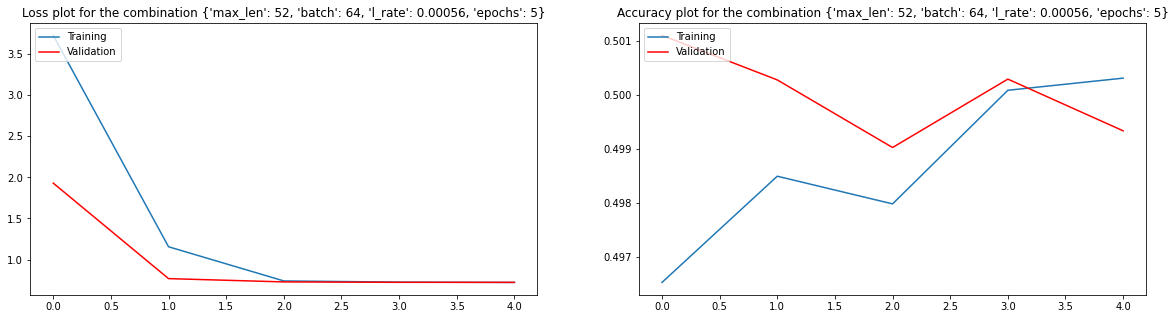

 40%|████      | 4/10 [01:51<02:25, 24.30s/it, best loss: -0.5]

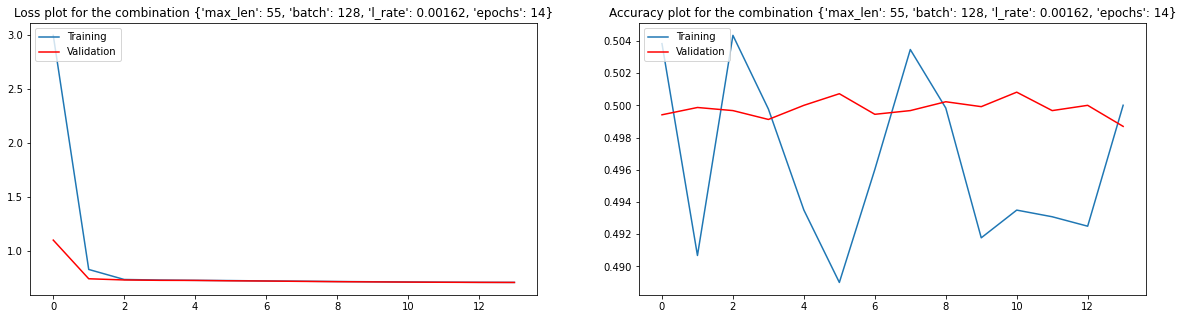

 50%|█████     | 5/10 [02:13<01:58, 23.62s/it, best loss: -0.5]

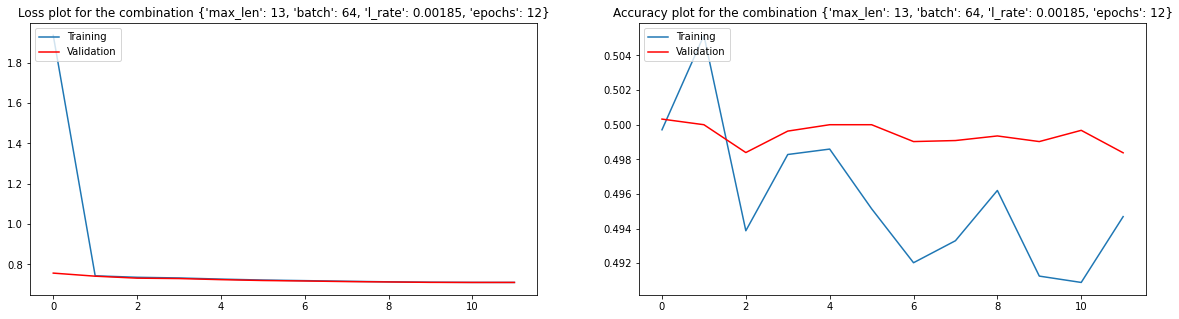

 60%|██████    | 6/10 [02:38<01:45, 26.39s/it, best loss: -0.5]


KeyboardInterrupt: ignored

In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)

    encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])
    validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding='post', truncating = 'pre')
    
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn_em(embedding_matrix, 300, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_data = (validation_padded, validation['Sentiment']))
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = round(learning_rate,5)
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_vanilla_rnn_em = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_vanilla_rnn_em)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

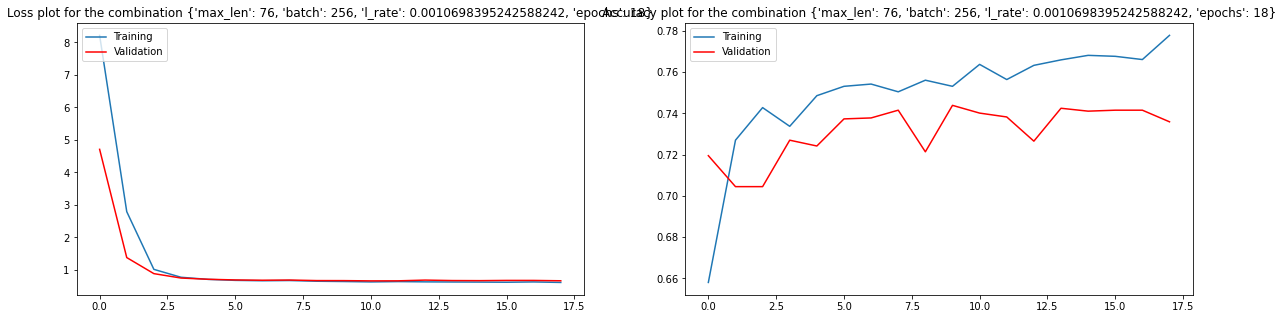

 10%|█         | 1/10 [00:19<02:54, 19.39s/it, best loss: -0.74]

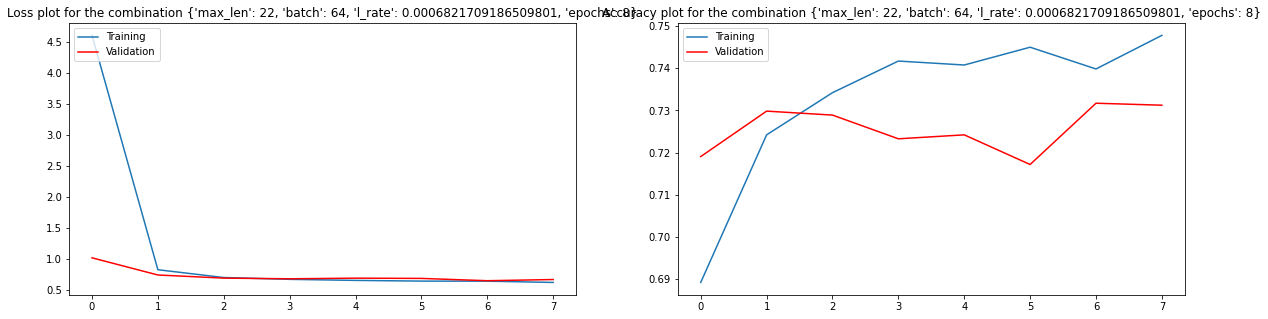

 20%|██        | 2/10 [00:28<02:09, 16.18s/it, best loss: -0.74]

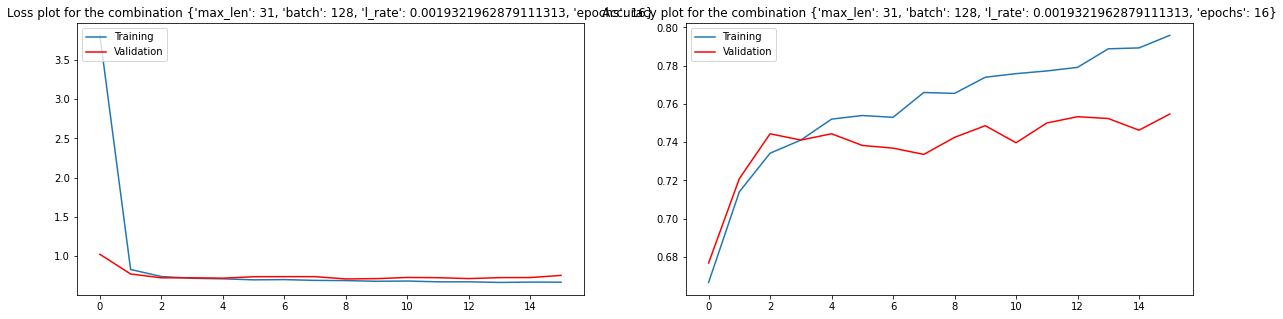

 30%|███       | 3/10 [00:40<01:44, 14.90s/it, best loss: -0.75]

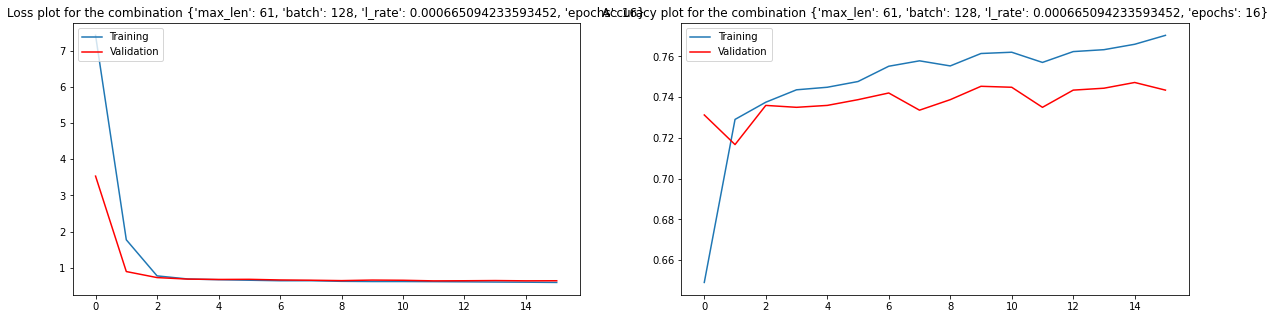

 40%|████      | 4/10 [00:57<01:34, 15.78s/it, best loss: -0.75]

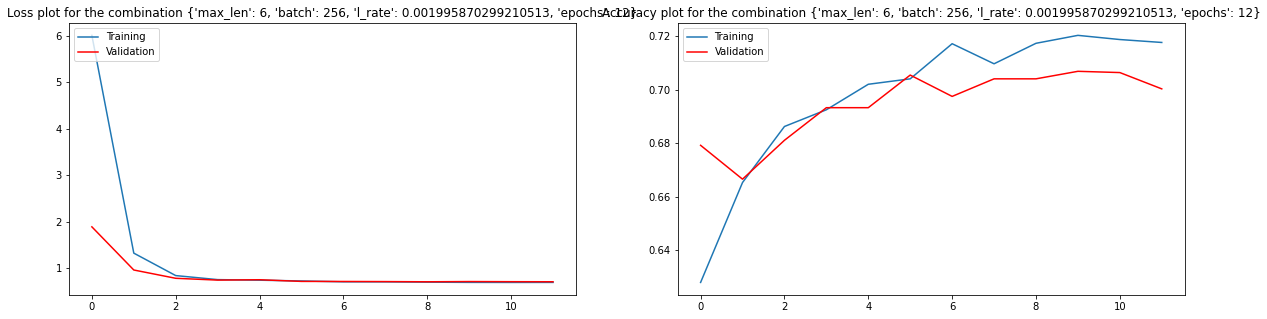

 50%|█████     | 5/10 [01:03<01:03, 12.67s/it, best loss: -0.75]

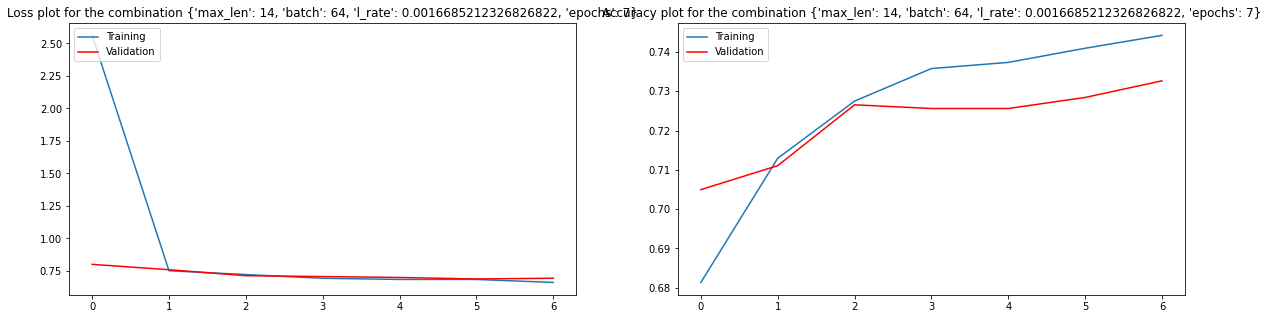

 60%|██████    | 6/10 [01:10<00:43, 10.97s/it, best loss: -0.75]

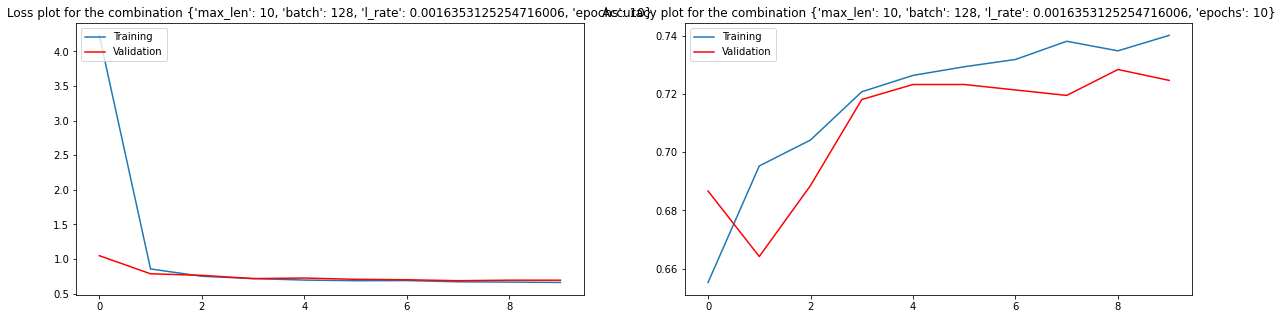

 70%|███████   | 7/10 [01:16<00:28,  9.63s/it, best loss: -0.75]

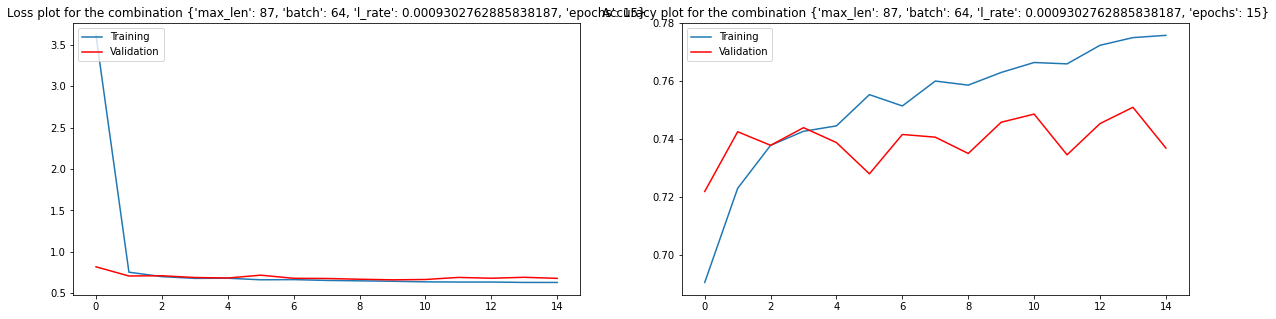

 80%|████████  | 8/10 [01:46<00:31, 15.65s/it, best loss: -0.75]

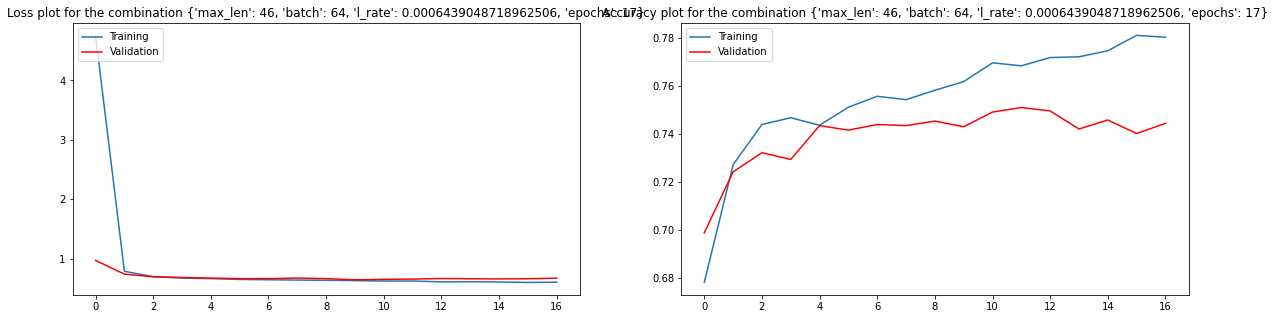

 90%|█████████ | 9/10 [02:07<00:17, 17.38s/it, best loss: -0.75]

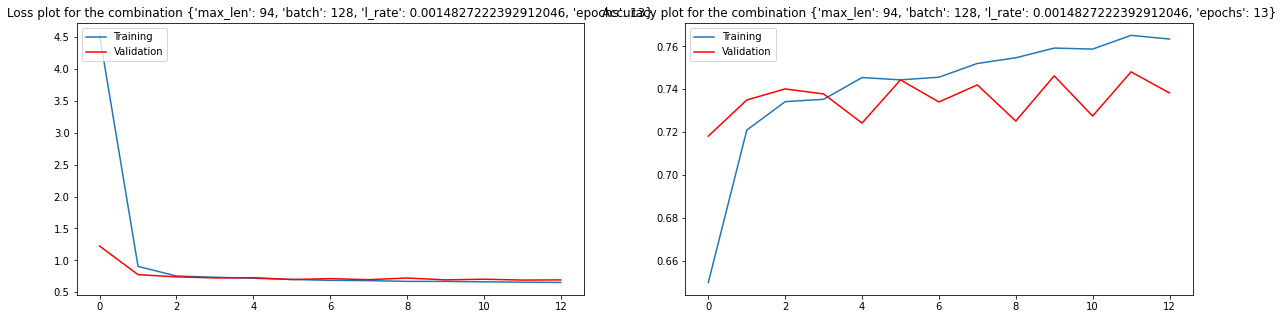

100%|██████████| 10/10 [02:28<00:00, 14.82s/it, best loss: -0.75]
{'batch_size': 1, 'epochs': 11, 'learning_rate': 0.0019321962879111313, 'max_length': 27}


In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_lstm_em(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = learning_rate
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_lstm_em = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_lstm_em)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

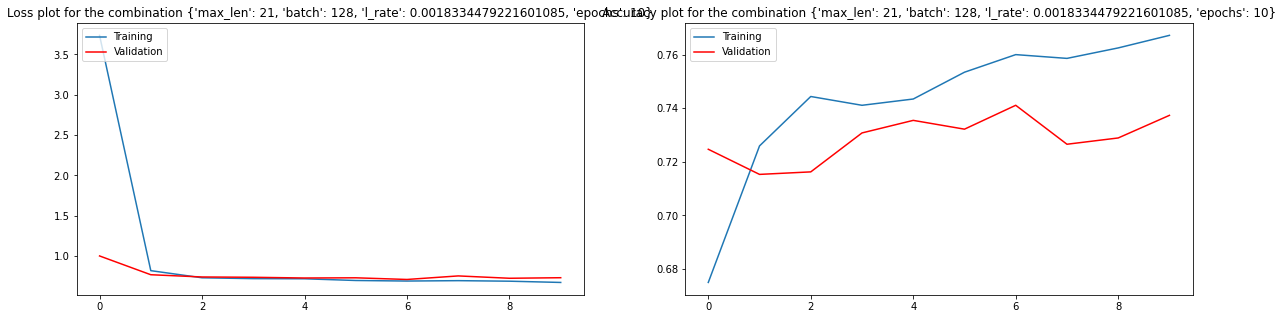

 10%|█         | 1/10 [00:07<01:05,  7.30s/it, best loss: -0.74]

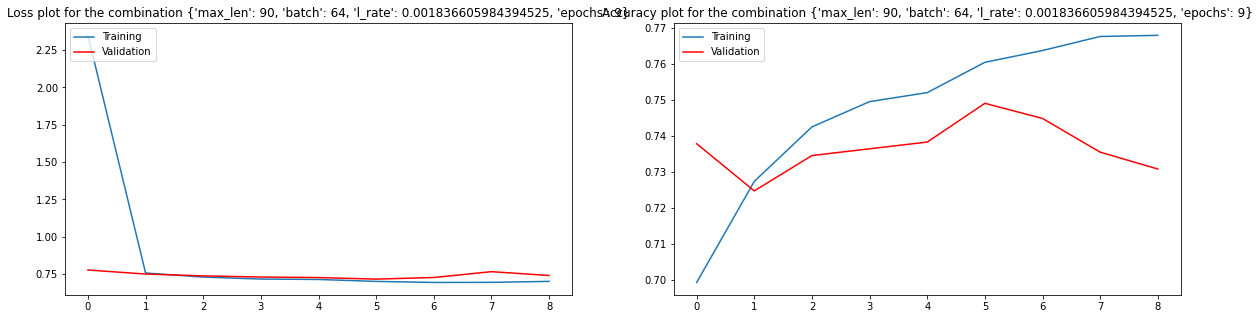

 20%|██        | 2/10 [00:24<01:22, 10.33s/it, best loss: -0.74]

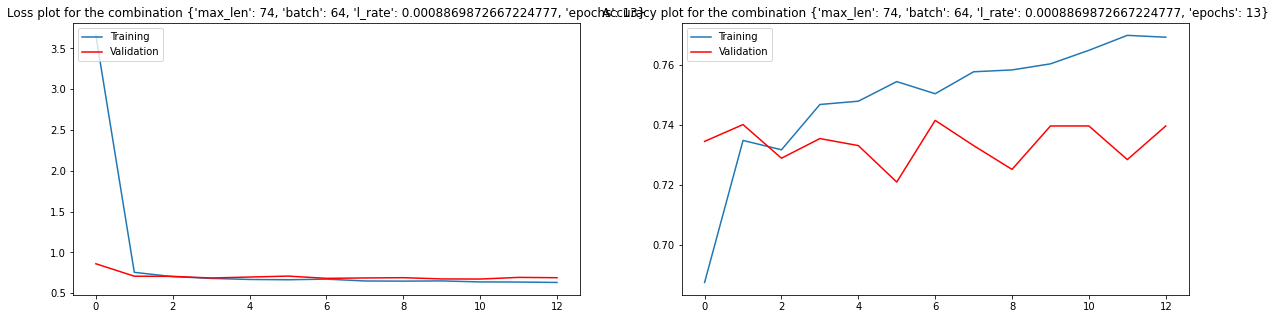

 30%|███       | 3/10 [00:46<01:35, 13.63s/it, best loss: -0.74]

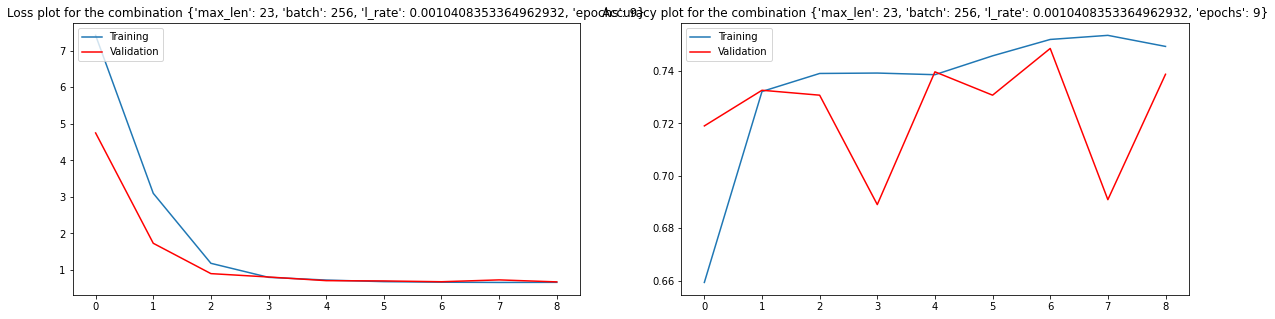

 40%|████      | 4/10 [00:51<01:07, 11.28s/it, best loss: -0.74]

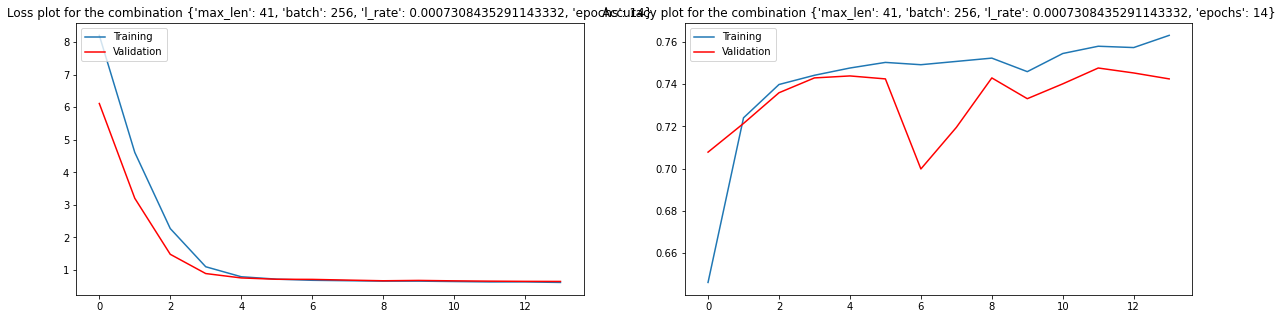

 50%|█████     | 5/10 [01:01<00:54, 10.94s/it, best loss: -0.74]

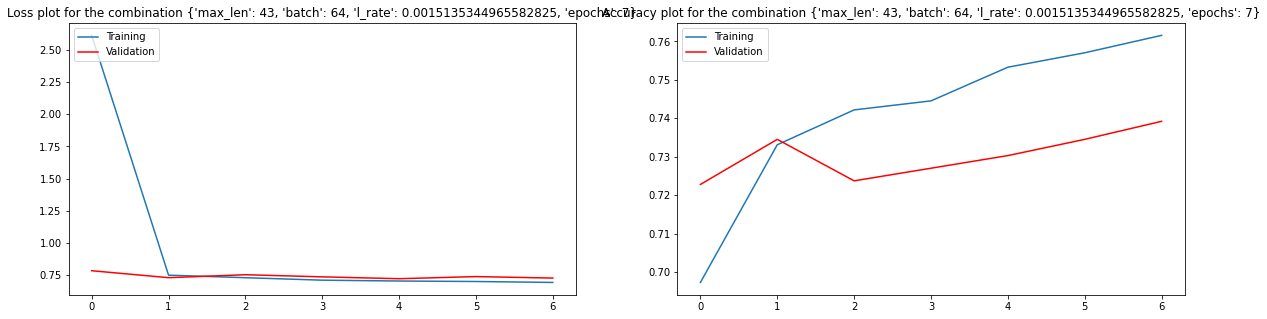

 60%|██████    | 6/10 [01:11<00:42, 10.51s/it, best loss: -0.74]

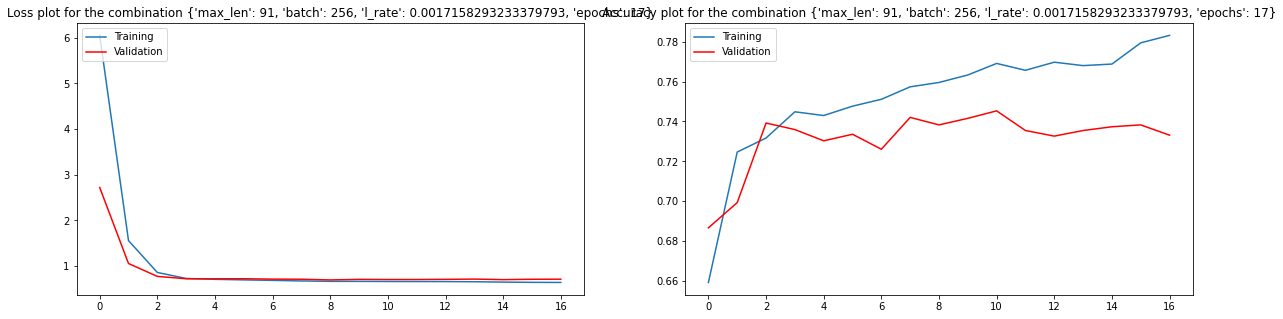

 70%|███████   | 7/10 [01:30<00:39, 13.21s/it, best loss: -0.74]

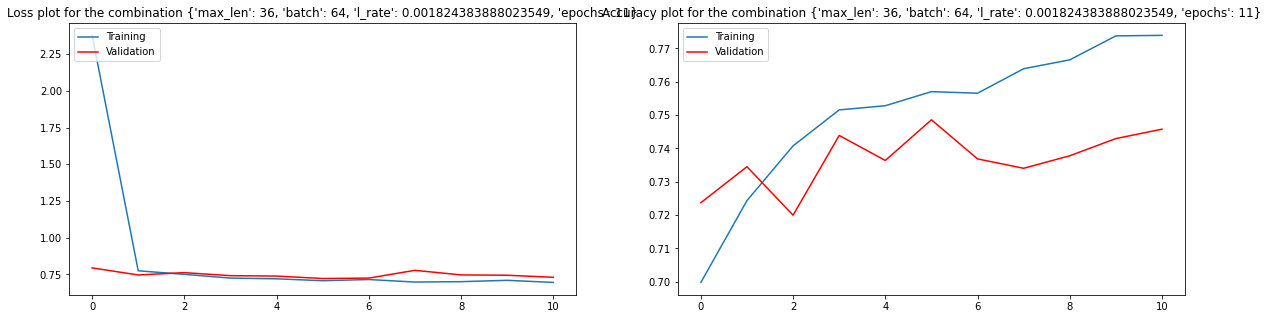

 80%|████████  | 8/10 [01:43<00:26, 13.09s/it, best loss: -0.75]

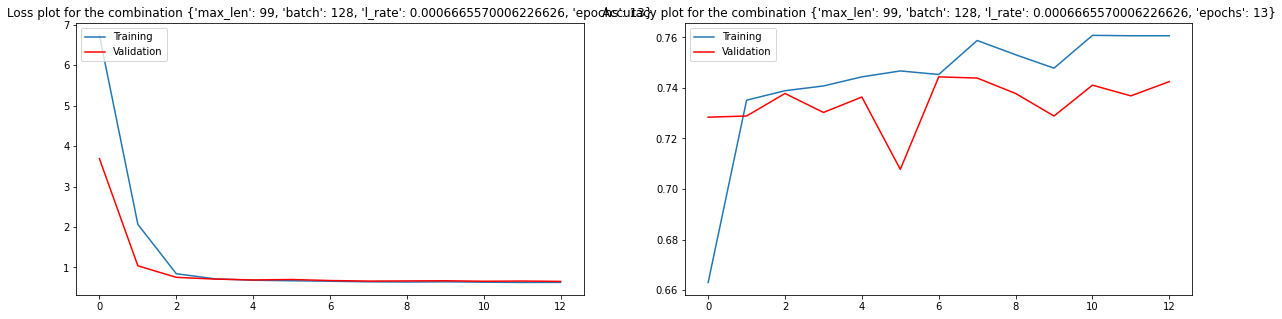

 90%|█████████ | 9/10 [02:03<00:15, 15.05s/it, best loss: -0.75]

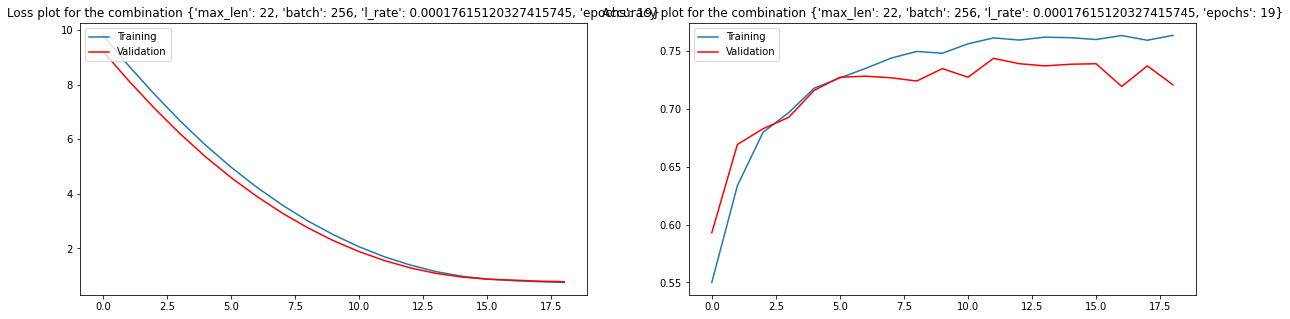

100%|██████████| 10/10 [02:12<00:00, 13.27s/it, best loss: -0.75]
{'batch_size': 0, 'epochs': 6, 'learning_rate': 0.001824383888023549, 'max_length': 32}


In [ ]:
def objective_func(args):
    max_length = args['max_length']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    epochs = args['epochs']

    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_gru_em(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    u = {}
    u['max_len'] = max_length
    u['batch'] = batch_size
    u['l_rate'] = learning_rate
    u['epochs'] = epochs

    fig, ax = plt.subplots(1,2,figsize = (20,5))

    ax[0].plot(history.history['loss'], label='Training')
    ax[0].plot(history.history['val_loss'], c='r',label='Validation')
    ax[0].legend(loc='upper left')
    ax[0].title.set_text('Loss plot for the combination ' + str(u))


    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], c='r',label='Validation')
    ax[1].legend(loc='upper left')
    ax[1].title.set_text('Accuracy plot for the combination ' + str(u))  
    plt.show()

#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)),  
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,0.002)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_gru_em = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_gru_em)

In [ ]:
# training.to_csv('Training Data.csv')
# test.to_csv('Test Data.csv')

In [ ]:
# def generate_embedding_matrix(word_embeddings):
#     vocabulary_size = len(tokenizer.word_index)+1
#     embedding_matrix = np.zeros((vocabulary_size, 300))
#     for word, index in tokenizer.word_index.items():
#         embedding_vector = word_embeddings.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[index] = embedding_vector
#     return embedding_matrix,vocabulary_size

In [ ]:
# input_len = 50
# tokenizer = Tokenizer(oov_token='<OOV>')
# tokenizer.fit_on_texts(training['Doc Text'])
# X_train_processed = tokenizer.texts_to_sequences(training['Doc Text'])
# X_train_processed = pad_sequences(X_train_processed, padding='post', maxlen=input_len,truncating='pre')
# embedding_matrix,vocabulary_size = generate_embedding_matrix(embeddings)
# tf.keras.backend.clear_session()
# model = Sequential()
# embedding_layer = Embedding(vocabulary_size, 300, weights=[embedding_matrix], input_length=input_len,trainable = False,mask_zero=True)
# model.add(embedding_layer)
# model.add(SimpleRNN(300,kernel_regularizer = tf.keras.regularizers.L1(0.01)))

# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# # adam_optimizer = optimizers.adam(learning_rate=learning_rate)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print(model.summary())
# model.fit(X_train_processed, training['Sentiment'], batch_size=128, epochs=30, verbose=1)

In [ ]:
def model_vanilla_rnn_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(SimpleRNN(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [ ]:
max_length = 40
epochs = 15
learning_rate = 0.001
batch_size = 64
encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
model = model_vanilla_rnn_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True, validation_split = 0.25)
accuracy = history.history['val_accuracy'][-1]

Epoch 1/15
126/126 [==============================] - 42s 335ms/step - loss: 5.1197 - accuracy: 0.6622 - val_loss: 2.0090 - val_accuracy: 0.6917
Epoch 2/15
126/126 [==============================] - 41s 324ms/step - loss: 1.2526 - accuracy: 0.7154 - val_loss: 0.8993 - val_accuracy: 0.7223
Epoch 3/15
126/126 [==============================] - 42s 337ms/step - loss: 0.8545 - accuracy: 0.7227 - val_loss: 0.8080 - val_accuracy: 0.7123
Epoch 4/15
126/126 [==============================] - 42s 333ms/step - loss: 0.7917 - accuracy: 0.7279 - val_loss: 0.7485 - val_accuracy: 0.7322
Epoch 5/15
126/126 [==============================] - 41s 324ms/step - loss: 0.7515 - accuracy: 0.7346 - val_loss: 0.7596 - val_accuracy: 0.7093
Epoch 6/15
126/126 [==============================] - 41s 323ms/step - loss: 0.7265 - accuracy: 0.7335 - val_loss: 0.7388 - val_accuracy: 0.7207
Epoch 7/15
126/126 [==============================] - 42s 333ms/step - loss: 0.7380 - accuracy: 0.7310 - val_loss: 0.7363 - val_ac

In [ ]:
def model_lstm_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, activation, Dropout_rate, kernel_regularizer_coef, activity_regularizer_coef):

    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable = False)
    model.add(e)
    model.add(Bidirectional(LSTM(units = 300, activation = activation, kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef))))
    model.add(Dropout(Dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer_coef), activity_regularizer=tf.keras.regularizers.L2(activity_regularizer_coef)))
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    return model


In [ ]:
max_length = 40
epochs = 20
learning_rate = 0.001
batch_size = 128
encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
model = model_lstm_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)

history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=1, batch_size=batch_size, shuffle =True, validation_split = 0.25)
accuracy = history.history['val_accuracy'][-1]

Epoch 1/20
63/63 [==============================] - 74s 1s/step - loss: 9.0225 - accuracy: 0.6624 - val_loss: 1.3562 - val_accuracy: 0.7123
Epoch 2/20
63/63 [==============================] - 73s 1s/step - loss: 0.9291 - accuracy: 0.7110 - val_loss: 0.7748 - val_accuracy: 0.7314
Epoch 3/20
63/63 [==============================] - 76s 1s/step - loss: 0.7501 - accuracy: 0.7287 - val_loss: 0.7347 - val_accuracy: 0.7391
Epoch 4/20
63/63 [==============================] - 75s 1s/step - loss: 0.7241 - accuracy: 0.7325 - val_loss: 0.7345 - val_accuracy: 0.7207
Epoch 5/20
63/63 [==============================] - 74s 1s/step - loss: 0.7086 - accuracy: 0.7361 - val_loss: 0.7189 - val_accuracy: 0.7376
Epoch 6/20
63/63 [==============================] - 75s 1s/step - loss: 0.6910 - accuracy: 0.7414 - val_loss: 0.6886 - val_accuracy: 0.7406
Epoch 7/20
63/63 [==============================] - 75s 1s/step - loss: 0.6857 - accuracy: 0.7417 - val_loss: 0.6896 - val_accuracy: 0.7399
Epoch 8/20
63/63 [==

In [ ]:
def objective_func(args):
    max_length = args['max_length']
#     af_in_simpleRNN = args['af_in_simpleRNN']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
#     padd = args['padd']
#     trunc = args['trunc']
    epochs = args['epochs']
#     kernel_regularizer_coef = args['kernel_regularizer_coef']
#     activity_regularizer_coef = args['activity_regularizer_coef']
#     Dropout_rate = args['Dropout_rate']
    
    encoded_train = tokenise_tf.texts_to_sequences(training['Doc Text'])
    training_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post', truncating = 'pre')
    embedding_matrix, vocab_size = emb_matrix(tokenise_tf, embeddings)
    adam_optimizer = optimizers.Adam(learning_rate=learning_rate)
    model = model_vanilla_rnn_bd(embedding_matrix, vocab_size, max_length, adam_optimizer, 'tanh', 0.2, 0.001, 0.001)
    
    history = model.fit(training_padded, training['Sentiment'], epochs=epochs, verbose=0, batch_size=batch_size, shuffle =True, validation_split = 0.25)
    accuracy = history.history['val_accuracy'][-1]
    
    # summarize history for accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()    
    
#     encoded_validation = tokenise_tf.texts_to_sequences(validation['Doc Text'])

#     validation_padded = pad_sequences(encoded_validation, maxlen=max_length, padding=padd, truncating = trunc)
#     loss, accuracy = model.evaluate(validation_padded, validation['Sentiment'], verbose=0)
    return -round((accuracy),2)

space = {'max_length': hp.choice('max_length',range(4,100)), 
#          'af_in_simpleRNN': hp.choice('af_in_simpleRNN', ['tanh', 'sigmoid']), 
        'batch_size': hp.choice('batch_size', [64, 128, 256]),
#          'padd': hp.choice('padd', ['pre', 'post']),
#          'trunc': hp.choice('trunc', ['pre', 'post']),
         'epochs': hp.choice('epochs',range(5,20)), 
         'learning_rate': hp.uniform('learning_rate', 0,1)
#          'Dropout_rate': hp.uniform('Dropout_rate', 0, 1),
#          'kernel_regularizer_coef': hp.uniform('kernel_regularizer_coef', 0, 10),
#          'activity_regularizer_coef': hp.uniform('activity_regularizer_coef', 0, 10)
        }
                                
                                
tokenise_tf = Tokenizer()
tokenise_tf.fit_on_texts(training['Doc Text'])                                
best_vanilla_rnn_bd = fmin(objective_func, space, algo=tpe.suggest, max_evals=10)
print(best_vanilla_rnn_bd)

  0%|          | 0/10 [20:12<?, ?trial/s, best loss=?]


KeyboardInterrupt: 